In [1]:
import pandas as pd
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np
import nltk

In [2]:
german_stop_words = stopwords.words('german')
german_stop_words.append("fur")

In [3]:
# CONSTANTS
DATA_PATH = "D:/10kgerdataset/"
TRAIN_CSV = "train.csv"
TEST_CSV = "test.csv"

In [4]:
try:
    df_train = pd.read_csv(os.path.join(DATA_PATH, TRAIN_CSV))
    df_test = pd.read_csv(os.path.join(DATA_PATH, TEST_CSV))
except FileNotFoundError:
    print("File was not found at specific location.")
    raise

In [5]:
def remove_punctuation(document: str) -> str:
    return re.sub(r'[^\w\s]', '', document)

def remove_numbers(document: str) -> str:
    return re.sub(r'$\d+\W+|\b\d+\b|\W+\d+$', '', document)

def map_umlaut(document: str) -> str:
    umlaut_mapping = {
        "ß": "b",
        "ü": "u",
        "ä": "a",
        "ö": "o",
        "ë": "e",
    }
    for k, v in umlaut_mapping.items():
        document = document.replace(k, v)
    return document

def stop_word_removal(document: str) -> str:
    return " ".join(w for w in document.split() if w not in german_stop_words)

In [6]:
def run_pre_processing_pipeline(df):
    new_df = df.copy(deep=False)
    
    new_df["text"] = new_df["text"].str.lower()
    new_df["label"] = new_df["label"].str.lower()
    
    new_df = new_df.dropna()
    
    new_df["text"] = new_df["text"].apply(remove_punctuation)
    new_df["text"] = new_df["text"].apply(remove_numbers)
    new_df["text"] = new_df["text"].apply(map_umlaut)
    new_df["text"] = new_df["text"].apply(stop_word_removal)
    return new_df

In [7]:
df_train = run_pre_processing_pipeline(df_train)
df_test = run_pre_processing_pipeline(df_test)

In [8]:
text_features = ["text"]

In [9]:
x_train = np.array(df_train["text"])
y_train = np.array(df_train["label"])
x_test = np.array(df_test["text"])
y_test = np.array(df_test["label"])

In [10]:
from catboost import Pool, CatBoostClassifier

In [11]:
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

In [12]:
train_pool = Pool(
    x_train, 
    y_train, 
    text_features=[0]
)
valid_pool = Pool(
    x_test, 
    y_test,
    text_features=[0]

)

catboost_params = {
    'iterations': 500,
    'learning_rate': 0.2,
    'eval_metric': 'Accuracy',
    'task_type': 'GPU',
    'early_stopping_rounds': 300,
    'use_best_model': True,
    'verbose': 500,
}

model = CatBoostClassifier(**catboost_params)
model.fit(train_pool, eval_set=valid_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7288548	test: 0.7470817	best: 0.7470817 (0)	total: 45.7ms	remaining: 22.8s
499:	learn: 0.9185834	test: 0.8570039	best: 0.8570039 (448)	total: 15.5s	remaining: 0us
bestTest = 0.8570038911
bestIteration = 448
Shrink model to first 449 iterations.


In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix    

In [14]:
y_pred = model.predict(valid_pool)
y_pred = y_pred.reshape(y_pred.shape[0])
y_true = y_test
labels = np.unique(y_true)

In [15]:
y_true.shape, y_pred.shape, labels.shape

((2056,), (2056,), (9,))

<AxesSubplot:title={'center':'Classification report for CatGnad model the test set.'}>

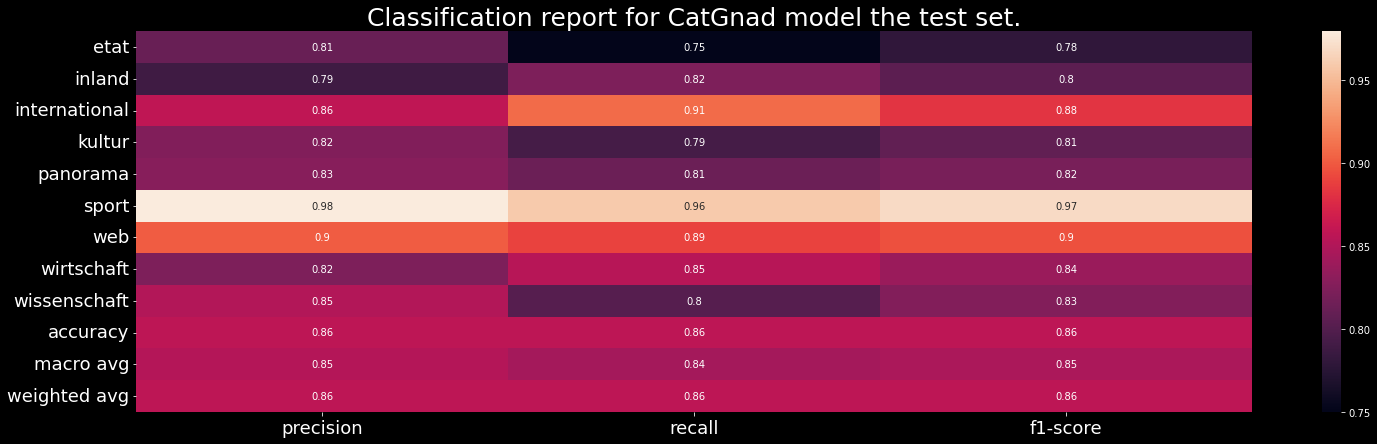

In [21]:
clf_report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
plt.style.use("dark_background")
fig_dims = (25, 7)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('Classification report for CatGnad model the test set.', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

In [23]:
cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix

array([[ 99,   2,  11,   9,   2,   2,   6,   1,   0],
       [  3, 167,   0,   2,  18,   0,   1,  10,   2],
       [  2,   5, 277,   1,  12,   0,   0,   8,   0],
       [  8,   4,   1,  99,   4,   0,   4,   4,   1],
       [  1,  17,  20,   5, 270,   1,   4,   6,   8],
       [  3,   0,   2,   0,   3, 238,   0,   2,   0],
       [  2,   7,   7,   1,   4,   0, 282,  12,   2],
       [  3,   6,   5,   0,   7,   2,  13, 233,   4],
       [  1,   4,   0,   3,   6,   0,   3,   7,  97]], dtype=int64)

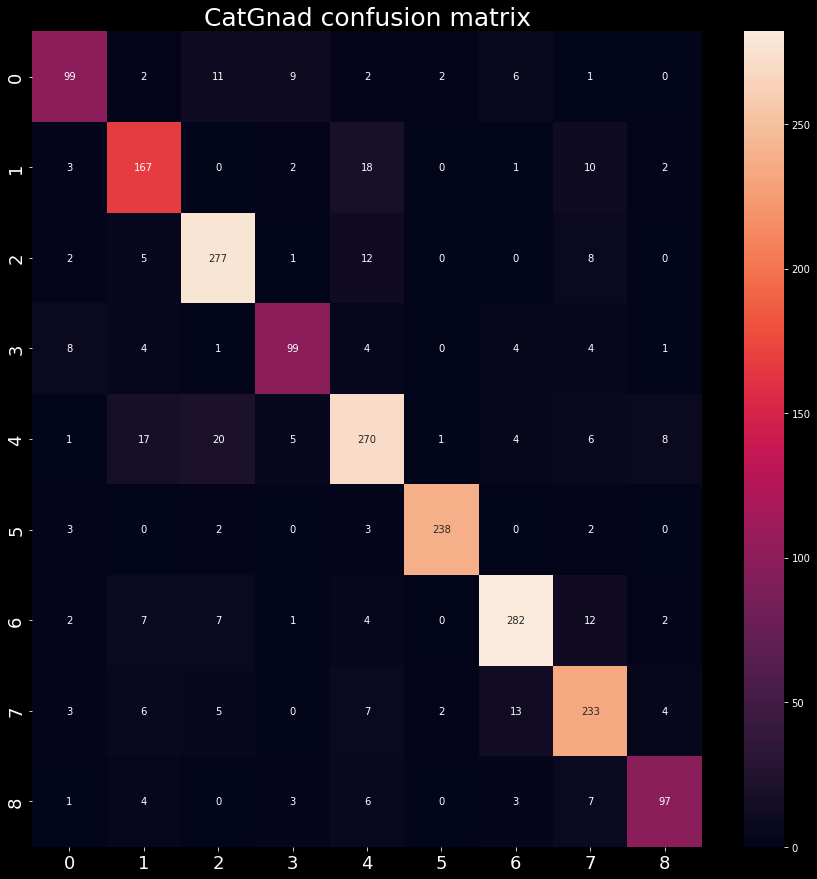

In [25]:
fig_dims = (15, 15)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('CatGnad confusion matrix', fontsize=25)
plt.xlabel('label', fontsize=24)
plt.ylabel('count', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 
ax = sns.heatmap(cf_matrix, annot=True, fmt='d')

In [27]:
model.save_model("CatGnad")

In [28]:
loaded_model = CatBoostClassifier()
loaded_model.load_model("CatGnad")

In [32]:
y_pred = loaded_model.predict(valid_pool)
y_pred = y_pred.reshape(y_pred.shape[0])
y_true = y_test
labels = np.unique(y_true)

In [34]:
print(classification_report(y_true, y_pred, target_names=labels))

               precision    recall  f1-score   support

         etat       0.81      0.75      0.78       132
       inland       0.79      0.82      0.80       203
international       0.86      0.91      0.88       305
       kultur       0.82      0.79      0.81       125
     panorama       0.83      0.81      0.82       332
        sport       0.98      0.96      0.97       248
          web       0.90      0.89      0.90       317
   wirtschaft       0.82      0.85      0.84       273
 wissenschaft       0.85      0.80      0.83       121

     accuracy                           0.86      2056
    macro avg       0.85      0.84      0.85      2056
 weighted avg       0.86      0.86      0.86      2056



# kfold training

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
df = pd.read_csv(os.path.join(DATA_PATH, "articles.csv"))

In [ ]:
df = run_pre_processing_pipeline(df)

In [ ]:
x = np.array(df["text"])
y = np.array(df["label"])

In [ ]:
kf = KFold(n_splits=5, shuffle=True)
models = []

In [ ]:
for i, (train_index, valid_index) in enumerate(kf.split(x)):
    x_train, y_train = x[train_index], y[train_index]
    x_test, y_test = x[valid_index], y[valid_index]
    
    train_pool = Pool(
        x_train, 
        y_train, 
        text_features=[0]
    )
    valid_pool = Pool(
        x_test, 
        y_test,
        text_features=[0]
    )
    
    model = CatBoostClassifier(**catboost_params)
    model.fit(train_pool, eval_set=valid_pool)
    models.append(model)